# Nirs analysis

## Import modules

In [16]:
import os
import glob
import codecs
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from scipy import stats
from scipy import interpolate
import matplotlib.pyplot as plt

In [17]:
class NirsAnalyzer():
    def __init__(self):
        self.measurement_period = 0.15
        self.num_columns = 70
        self.separation_char = '\t'
        self.data_table_start_row_index = 35
        self.num_channels = 22
        self.marker_column_name = 'mark'
        self.channel_names = ['ch-{}'.format(i+1) for i in range(self.num_channels)]

    def create_oxy_df(self, nirs_data_filepath):
        '''create dataframe that contains 'Mark' and 'Oxy-Hb' as columns'''
        # load nirs data and make (temporary) dataframe object
        temporary_names = np.arange(self.num_columns).astype(str)
        temporary_df = pd.read_csv(
            nirs_data_filepath, 
            names=temporary_names, 
            sep=self.separation_char, 
            low_memory=False
        )
        # extract columns and create dataframe
        time_column_name = temporary_names[0]
        marker_column_name = temporary_names[2]
        channel_column_names = temporary_names[4::3]
        oxy_data = temporary_df[[time_column_name, marker_column_name, *channel_column_names]][self.data_table_start_row_index:].values
        column_labels = ['time', 'mark', *self.channel_names]
        oxy_df = pd.DataFrame(
            oxy_data,
            columns=column_labels
        )
        experiment_date = os.path.splitext(os.path.basename(nirs_data_filepath))[0].split('-')[0]
        oxy_df.insert(0, 'experiment_date', (np.full(len(oxy_df), experiment_date)))
        return oxy_df
    
    def format_oxy_df(self, oxy_df):
        # find valid marker indexes
        finding_marker_query_statement = 'mark !=0 and mark !="0"'
        marker_indexes = oxy_df.query(finding_marker_query_statement).index.values
        marker_differences = marker_indexes[1:] - marker_indexes[:-1]
        valid_marker_boolean_indexes = [*(marker_differences > num_trial_samples), True]
        marker_indexes = marker_indexes[valid_marker_boolean_indexes]
        num_trials = marker_indexes.shape[0]
        # add two columns('trial_count', 'trial_category') to oxy_df
        trial_counts = np.zeros(len(oxy_df))
        trial_categories = np.full(len(oxy_df), '', dtype=object)
        for i, marker_index in enumerate(marker_indexes):
            trial_counts[marker_index:] = i+1
            trial_categories[marker_index:marker_index+num_preceding_rest_samples] = 'preceding_rest'
            trial_categories[marker_index+num_preceding_rest_samples:marker_index+num_preceding_rest_samples+num_task_samples] = 'task'
            trial_categories[marker_index+num_preceding_rest_samples+num_task_samples:marker_index+num_preceding_rest_samples+num_task_samples+num_following_rest_samples] = 'following_rest'
            trial_categories[marker_index+num_preceding_rest_samples+num_task_samples+num_following_rest_samples:] = 'questionnaire'
        oxy_df.insert(1, 'trial_count', trial_counts.astype(int))
        oxy_df.insert(2, 'trial_category', trial_categories)
        oxy_df = oxy_df.drop('mark', axis=1)
        return oxy_df
    


## Global constants

In [18]:
num_columns = 70
separation_char = '\t'
marker_column_name = 'mark'
data_table_start_row_index = 35
num_channels = 22
channel_names = ['ch-{}'.format(i+1) for i in range(num_channels)]
measurement_period = 0.15     # [sec]
preceding_rest_duration = 45  # [sec]
task_duration = 30            # [sec]
following_rest_duration = 45  # [sec]
num_preceding_rest_samples = int(preceding_rest_duration/measurement_period)
num_task_samples = int(task_duration/measurement_period)
num_following_rest_samples = int(following_rest_duration/measurement_period)
num_trial_samples = num_preceding_rest_samples + num_task_samples + num_following_rest_samples

## Load questionnaire data

In [19]:
def create_questionnaire_result_df(questionnaire_data_filepath):
    questionnaire_result_df = pd.read_csv(
        questionnaire_data_filepath, 
        index_col=0, 
    )
    experiment_date = os.path.splitext(os.path.basename(questionnaire_data_filepath))[0].split('-')[0]
    questionnaire_result_df.insert(0, 'experiment_date', (np.full(len(questionnaire_result_df), experiment_date)))
    return questionnaire_result_df

def format_questionnaire_result_df(questionnaire_result_df):
    questionnaire_result_df.insert(0, 'trial_count', (np.arange(len(questionnaire_result_df))+1).astype(str))
    questionnaire_contents = questionnaire_result_df.columns.values[3:]
    questionnaire_ids = ['q{}'.format(i+1) for i in range(questionnaire_contents.shape[0])]
    mapper = {}
    for questionnaire_content, questionnaire_id in zip(questionnaire_contents, questionnaire_ids):
        mapper[questionnaire_content] = questionnaire_id
    questionnaire_result_df = questionnaire_result_df.rename(columns=mapper)
    type_cast_dict = {}
    for questionnaire_id in questionnaire_ids:
        type_cast_dict[questionnaire_id] = float
    questionnaire_result_df = questionnaire_result_df.astype(type_cast_dict)
    questionnaire_result_df = questionnaire_result_df.drop('image', axis=1)
    return questionnaire_result_df


questionnaire_data_filepath_list = [
    './experimental_data/questionnaire/0706.csv',
    './experimental_data/questionnaire/0713.csv',
]

# create dataframe contains questionnaire result
questionnaire_result_df = pd.DataFrame(index=[])
for questionnaire_data_filepath in questionnaire_data_filepath_list:
    questionnaire_result_df
    questionnaire_result_df = questionnaire_result_df.append(create_questionnaire_result_df(questionnaire_data_filepath), ignore_index=True)
# format questionnaire_reslt
questionnaire_result_df = format_questionnaire_result_df(questionnaire_result_df)
# # create dataframe contains questionnaire content 
# questionnaire_content_df = pd.DataFrame(
#     np.expand_dims(questionnaire_contents, axis=0), 
#     columns=questionnaire_ids
# )

# check dataframes
print('\n\n\nQuestionnaire results')
display(questionnaire_result_df)
# print('\n\n\nQuestionnaire contents')
# display(questionnaire_content_df)





Questionnaire results


,trial_count,experiment_date,q1,q2,q3,q4,q5,q6,q7,q8,q9
0,1,0706,2.0,2.0,3.0,2.0,2.0,3.0,3.0,2.0,2.0
1,2,0706,5.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,5.0
2,3,0706,2.0,3.0,3.0,2.0,3.0,3.0,2.0,3.0,3.0
3,4,0706,4.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0
4,5,0706,2.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0,3.0
5,6,0706,5.0,5.0,4.0,5.0,4.0,3.0,5.0,5.0,3.0
6,7,0706,2.0,2.0,3.0,2.0,2.0,3.0,2.0,2.0,2.0
7,8,0706,4.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,1.0
8,9,0706,4.0,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0
9,10,0706,3.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,2.0


## Load Nirs data




Oxy-Hb data


,experiment_date,trial_count,trial_category,time,ch-1,ch-2,ch-3,ch-4,ch-5,ch-6,...,ch-13,ch-14,ch-15,ch-16,ch-17,ch-18,ch-19,ch-20,ch-21,ch-22
0,0706,0,,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0706,0,,0.15,0.013329,0.003347,0.006012,0.003584,0.004006,0.001976,...,0.003206,0.003816,-0.000181,0.000277,0.004745,0.003753,0.003358,0.003304,0.001391,0.008503
2,0706,0,,0.3,0.002916,0.006703,0.013444,0.003939,0.0063,0.003742,...,0.004807,0.005375,0.002583,0.002466,0.00596,0.004189,0.006457,0.006509,0.004648,0.017187
3,0706,0,,0.45,0.005963,0.006726,0.012406,0.003952,0.003982,0.003726,...,0.004766,0.005664,0.001388,0.00403,0.006183,0.004608,0.004571,0.004903,0.004856,0.016734
4,0706,0,,0.6,0.00036,0.005889,0.011043,0.003035,0.00261,0.003046,...,0.001257,0.00406,-0.00309,0.00178,0.004345,0.005033,0.003023,0.002003,0.000677,0.019737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24755,0713,20,questionnaire,1737.300,-0.071698,-0.058509,-0.042237,0.033209,-0.065773,0.063947,...,-0.037005,-0.027884,0.006887,-0.015162,-0.029784,-0.028576,-0.009314,-0.061780,-0.001060,0.070055
24756,0713,20,questionnaire,1737.450,-0.064951,-0.058814,-0.042617,0.030935,-0.067479,0.064016,...,-0.040981,-0.027485,0.007266,-0.015991,-0.031610,-0.030835,-0.010556,-0.059402,-0.003844,0.067960
24757,0713,20,questionnaire,1737.600,-0.066047,-0.060842,-0.045839,0.026885,-0.071183,0.065581,...,-0.047664,-0.030606,0.004814,-0.017076,-0.035312,-0.032719,-0.011985,-0.054567,-0.009187,0.066070
24758,0713,20,questionnaire,1737.750,-0.073903,-0.063848,-0.049477,0.024036,-0.073848,0.067346,...,-0.053574,-0.032306,0.001804,-0.023427,-0.040371,-0.037321,-0.015537,-0.048710,-0.014751,0.063313


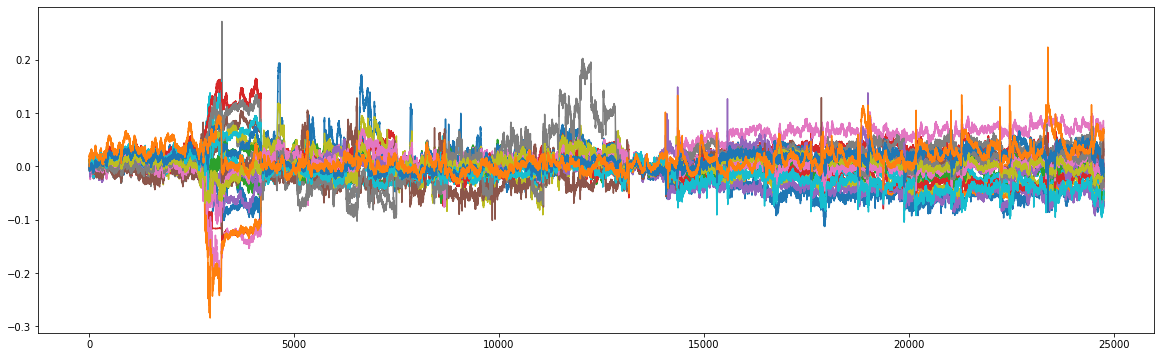

In [20]:
# define constants.
nirs_data_filepath_list = [
    './experimental_data/nirs/0706-main-01.TXT',
    './experimental_data/nirs/0706-main-02.TXT',
    './experimental_data/nirs/0706-main-03.TXT',
    './experimental_data/nirs/0706-main-04.TXT',
    './experimental_data/nirs/0713-main.TXT',
]

# initialize class: NirsAnalyzer
nirs_analyzer = NirsAnalyzer()

# create dataframe object that contains oxy-hb data
oxy_df = pd.DataFrame(index=[])
for nirs_data_filepath in nirs_data_filepath_list:
    oxy_df = oxy_df.append(nirs_analyzer.create_oxy_df(nirs_data_filepath), ignore_index=True)
# format oxy_df
oxy_df = nirs_analyzer.format_oxy_df(oxy_df)
# check dataframe
print('\n\n\nOxy-Hb data')
display(oxy_df)
# plot denoised oxy data
plt.figure(figsize=(20,6))
plt.plot(oxy_df[channel_names].values.astype(float))
plt.show()

## Denoise data using multi-resolution-analysis  

frequency -> 0.052083333333333336
period -> 19.2


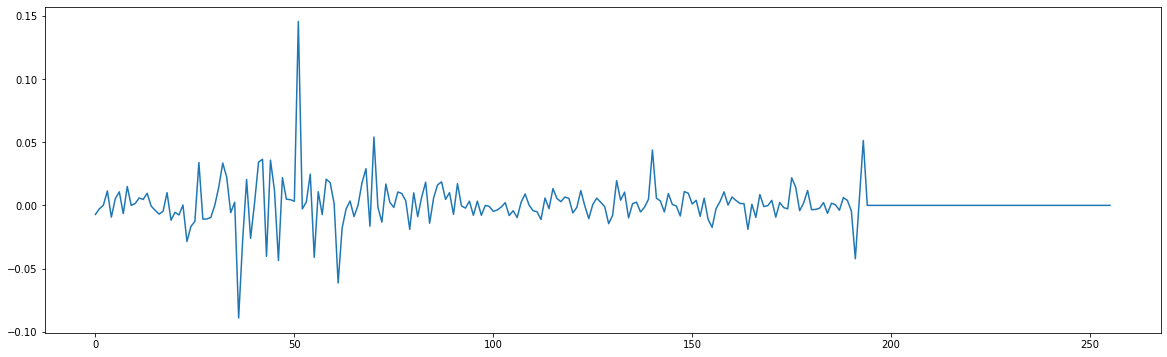

frequency -> 0.026041666666666668
period -> 38.4


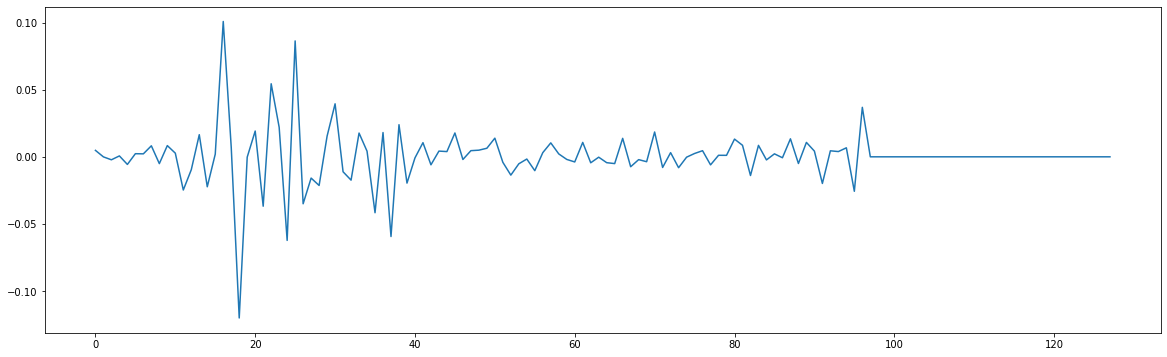

frequency -> 0.013020833333333334
period -> 76.8


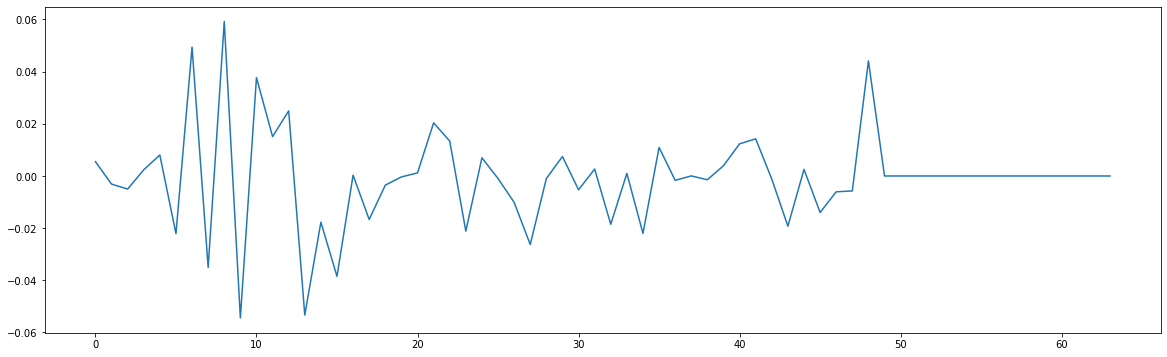

frequency -> 0.006510416666666667
period -> 153.6


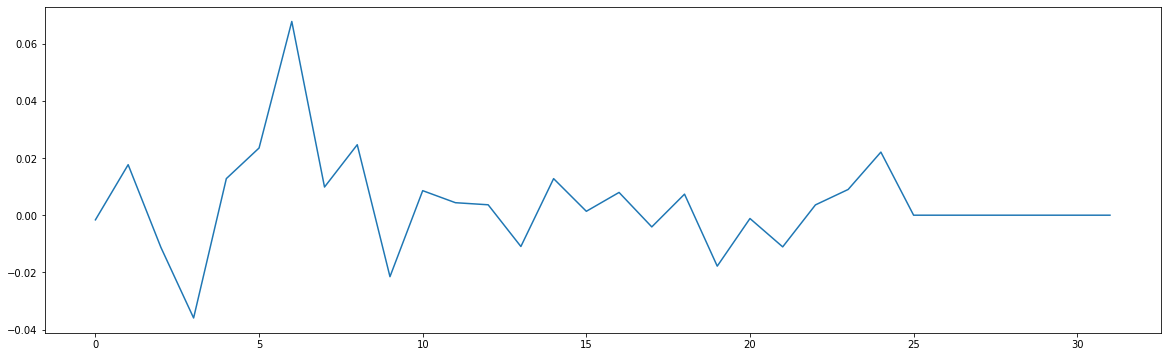




Denoised Oxy-Hb data


,experiment_date,trial_count,trial_category,time,ch-1,ch-2,ch-3,ch-4,ch-5,ch-6,...,ch-13,ch-14,ch-15,ch-16,ch-17,ch-18,ch-19,ch-20,ch-21,ch-22
0,0706,0,,0,0.00153998,-0.000145941,-0.00307548,-0.00473584,0.00574253,0.023068,...,0.0197091,0.0283152,0.00494489,-0.0171249,0.0135816,-0.00222791,0.0108158,0.0296564,0.0317779,0.0229919
1,0706,0,,0.15,0.00155762,-0.00014684,-0.00313295,-0.00478222,0.00565323,0.0230043,...,0.0196459,0.02827,0.00494975,-0.0170245,0.0135713,-0.00223713,0.0107186,0.0295885,0.0317596,0.0230112
2,0706,0,,0.3,0.00157525,-0.000147739,-0.00319043,-0.00482859,0.00556393,0.0229405,...,0.0195828,0.0282248,0.00495461,-0.0169242,0.0135609,-0.00224635,0.0106215,0.0295206,0.0317413,0.0230305
3,0706,0,,0.45,0.00159288,-0.000148639,-0.0032479,-0.00487496,0.00547462,0.0228768,...,0.0195196,0.0281796,0.00495948,-0.0168239,0.0135505,-0.00225557,0.0105243,0.0294526,0.031723,0.0230498
4,0706,0,,0.6,0.00161052,-0.000149538,-0.00330537,-0.00492134,0.00538532,0.0228131,...,0.0194564,0.0281344,0.00496434,-0.0167235,0.0135401,-0.00226479,0.0104272,0.0293847,0.0317047,0.0230691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24755,0713,20,questionnaire,1737.300,0.107059,0.0785143,0.0423986,-0.0447369,0.103669,-0.0338485,...,0.0297256,0.0180881,-0.0190096,-0.0189061,0.0180472,0.023143,0.0235869,0.0933196,-0.044804,-0.114505
24756,0713,20,questionnaire,1737.450,0.107771,0.0791845,0.0430053,-0.0449473,0.104559,-0.0341491,...,0.0302903,0.0183262,-0.0190532,-0.0187719,0.0184631,0.0237004,0.0238812,0.0942633,-0.0446805,-0.115112
24757,0713,20,questionnaire,1737.600,0.108483,0.0798547,0.043612,-0.0451577,0.105449,-0.0344496,...,0.0308549,0.0185643,-0.0190968,-0.0186377,0.018879,0.0242578,0.0241755,0.095207,-0.0445571,-0.115719
24758,0713,20,questionnaire,1737.750,0.109196,0.0805248,0.0442187,-0.045368,0.106338,-0.0347502,...,0.0314196,0.0188025,-0.0191403,-0.0185035,0.0192949,0.0248152,0.0244698,0.0961507,-0.0444336,-0.116326


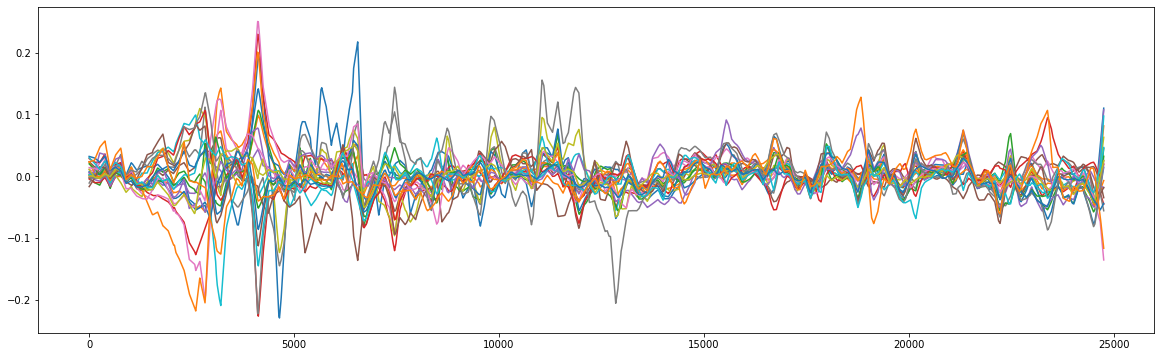

In [21]:
def get_minimum_power(number, base=2):
    '''get minimum power'''
    exponent = 0
    power = base ** exponent
    while power < number:
        exponent += 1
        power = base ** exponent
    return power

# note that changing value of 'minimum_frequency' or 'maximum_frequency' will make changes in results
oxy_df_column_labels = oxy_df.columns.values
num_information_columns = 4
info_labels = oxy_df_column_labels[:num_information_columns]
oxy_value_labels = oxy_df_column_labels[num_information_columns:]
info_values = oxy_df[info_labels].values
oxy_values = oxy_df[oxy_value_labels].values.astype(float).T
minimum_power_of_2 = get_minimum_power(oxy_values.shape[1])
num_paddings = minimum_power_of_2-oxy_values.shape[1]
wavelet_input = np.pad(oxy_values, [(0,0),(0,num_paddings)])
count = 0
period = measurement_period  # [sec]
frequency = 1/period  # [Hz]
minimum_frequency=0.006
maximum_frequency=0.06
denoised_oxy_values = np.zeros(wavelet_input.shape)
resample_x = np.linspace(0, wavelet_input.shape[1], wavelet_input.shape[1])
while wavelet_input.shape[1] > 1:
    count += 1
    period *= 2
    frequency = 1/period
    wavelet_output = wavelet_input[:, 1::2] - wavelet_input[:, 0::2]
    wavelet_input = wavelet_input[:, 0::2] + (wavelet_input[:, 1::2] - wavelet_input[:, 0::2])/2
    if minimum_frequency < frequency and frequency < maximum_frequency:
        resampled_wavelet_output = np.zeros(denoised_oxy_values.shape)
        for i, wavelet_output_per_channel in enumerate(wavelet_output):
            x = np.linspace(0, resample_x.shape[0], wavelet_output_per_channel.shape[0])
            interpolated_wavelet_output_per_channel = interpolate.interp1d(x, wavelet_output_per_channel, kind='linear')
            resampled_wavelet_output[i] = interpolated_wavelet_output_per_channel(resample_x)
        denoised_oxy_values += resampled_wavelet_output
        print('frequency -> {}'.format(frequency))
        print('period -> {}'.format(period))
        plt.figure(figsize=(20,6))
        plt.plot(wavelet_output[0])
        plt.show()
# zscored_and_denoised_oxy_values = stats.zscore(denoised_oxy_values[:, :-num_paddings], axis=1, ddof=1)
# denoised_oxy_data = np.hstack([info_values, zscored_and_denoised_oxy_values.T])
denoised_oxy_data = np.hstack([info_values, denoised_oxy_values[:, :-num_paddings].T])
denoised_oxy_df = pd.DataFrame(
    denoised_oxy_data,
    columns=oxy_df_column_labels
)
# check dataframe
print('\n\n\nDenoised Oxy-Hb data')
display(denoised_oxy_df)
# plot denoised oxy data
plt.figure(figsize=(20,6))
plt.plot(denoised_oxy_df[channel_names].values)
plt.show()

## Visualize data




Trial count -> 1


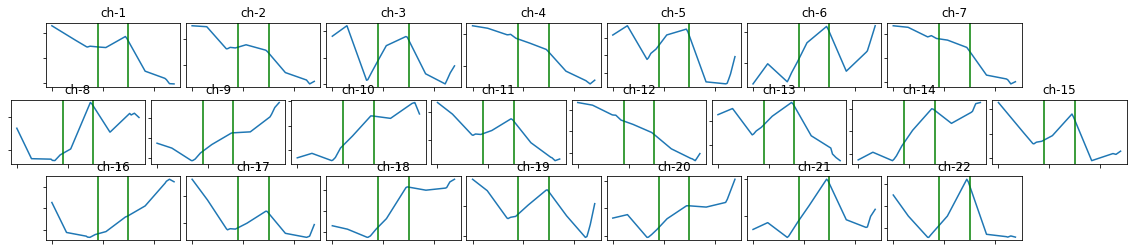

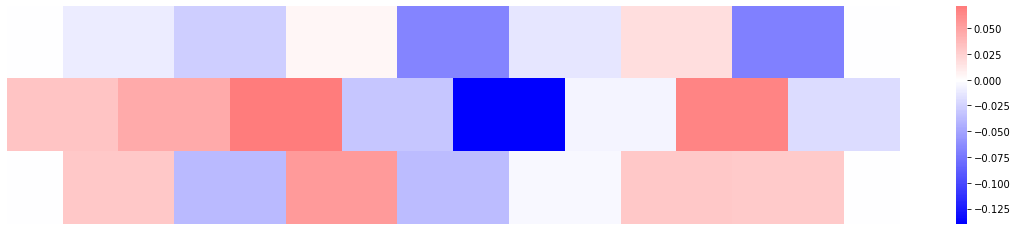




Trial count -> 2


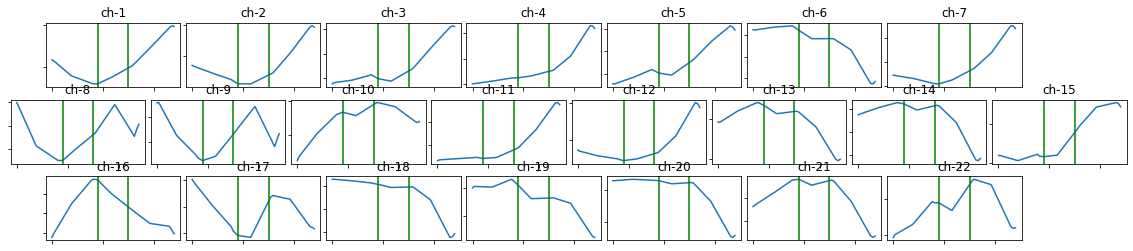

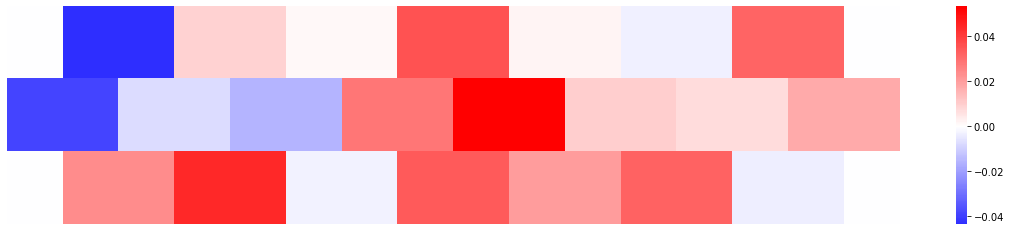




Trial count -> 3


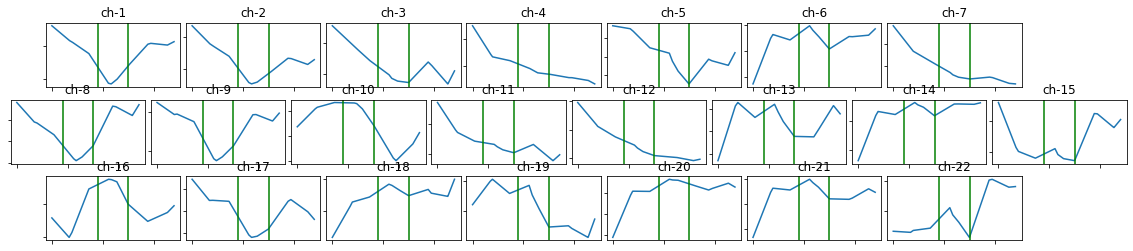

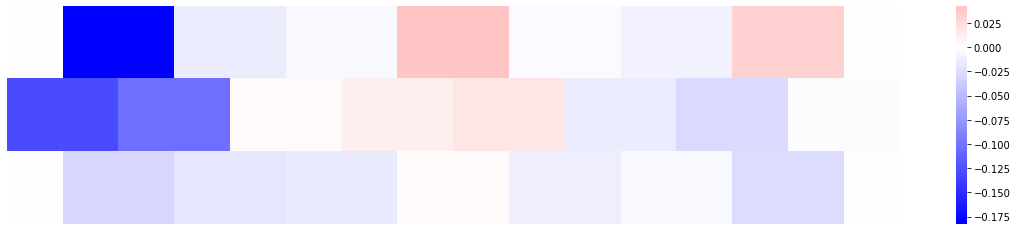




Trial count -> 4


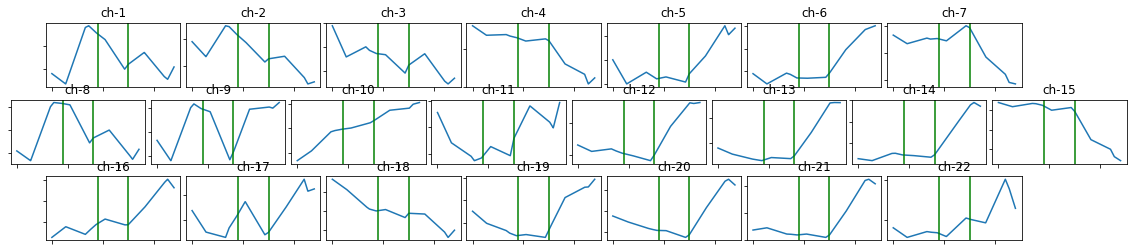

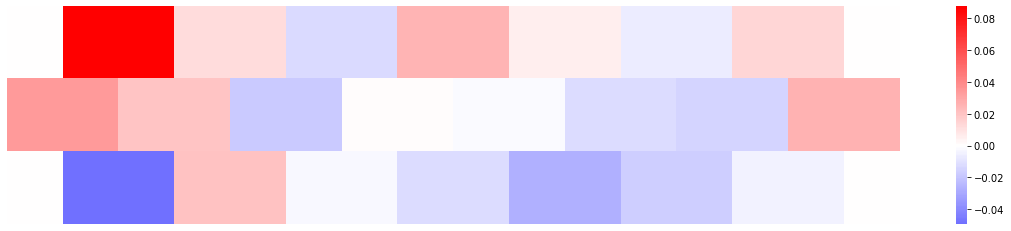




Trial count -> 5


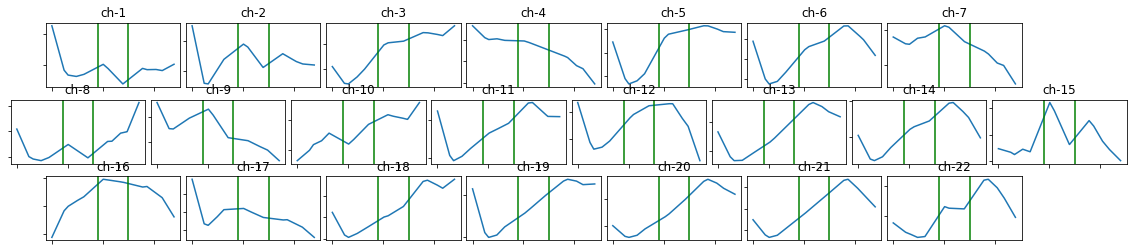

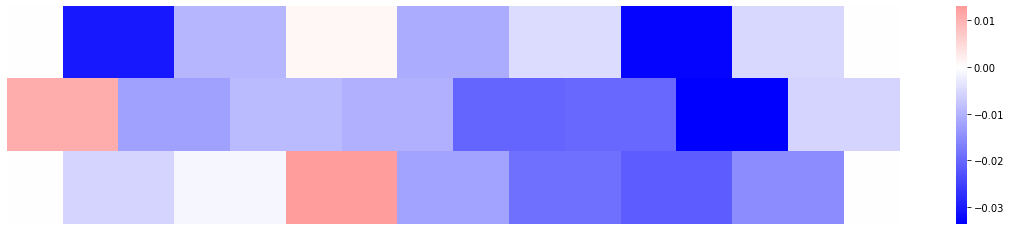




Trial count -> 6


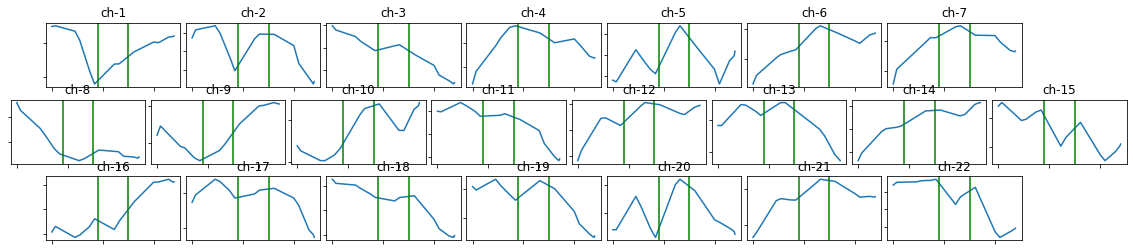

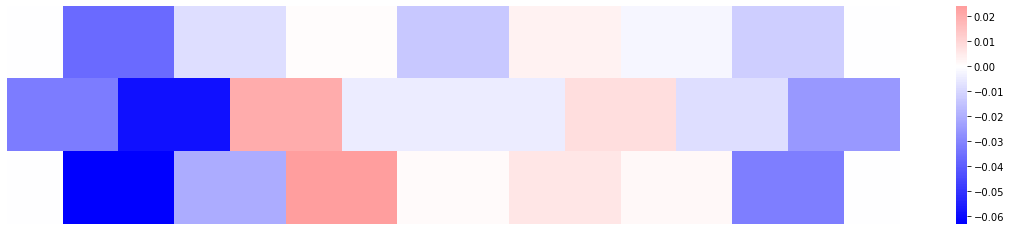




Trial count -> 7


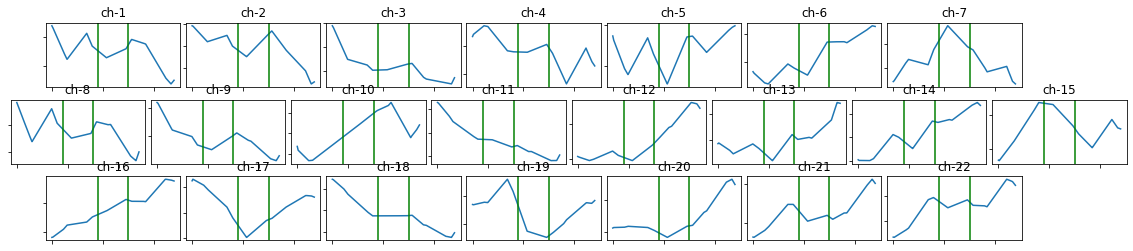

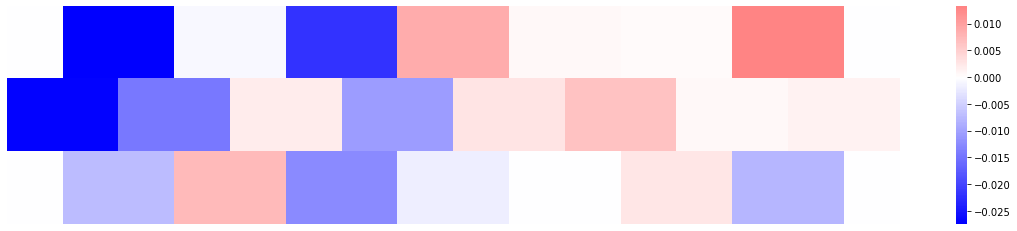




Trial count -> 8


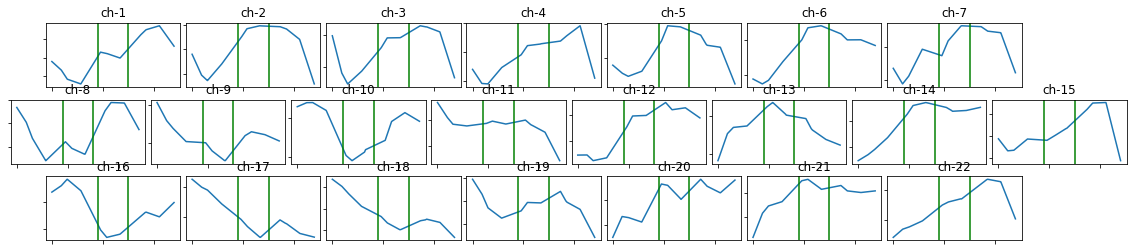

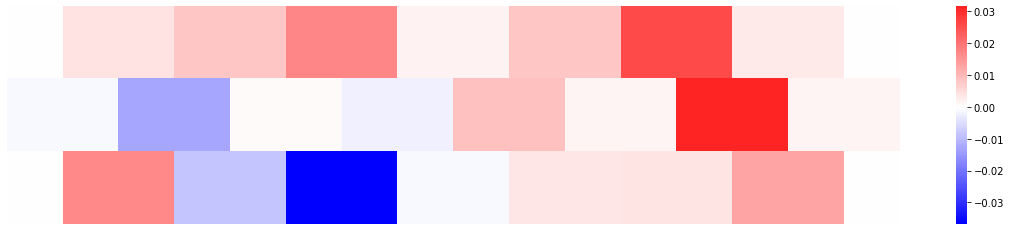




Trial count -> 9


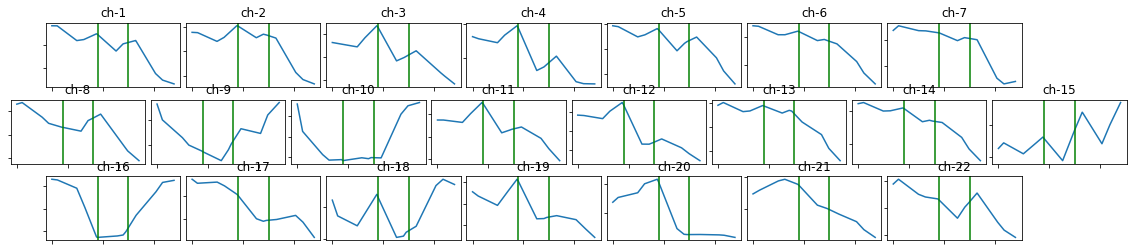

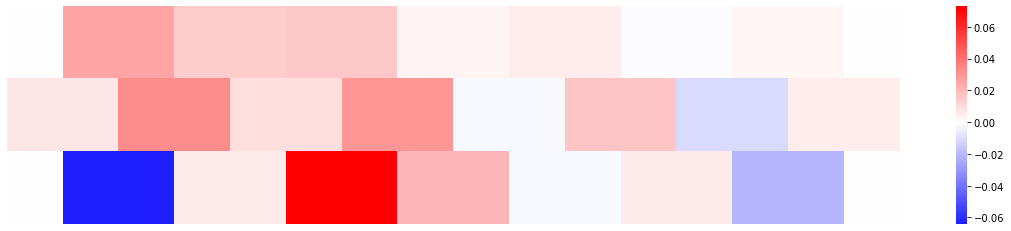




Trial count -> 10


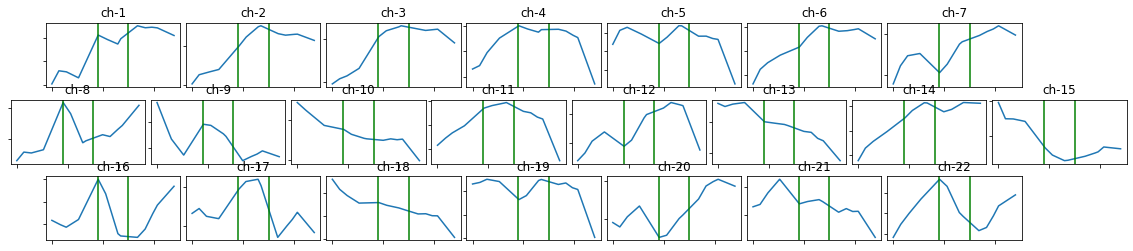

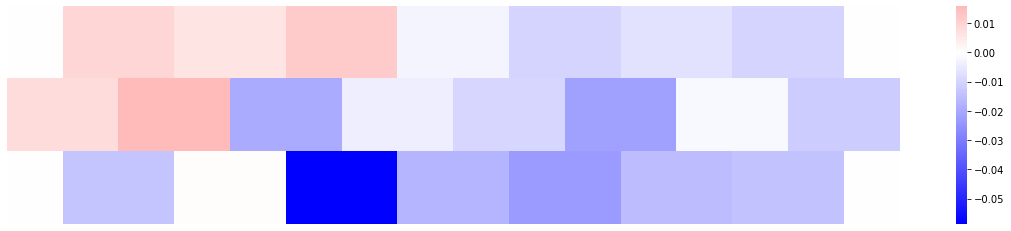




Trial count -> 11


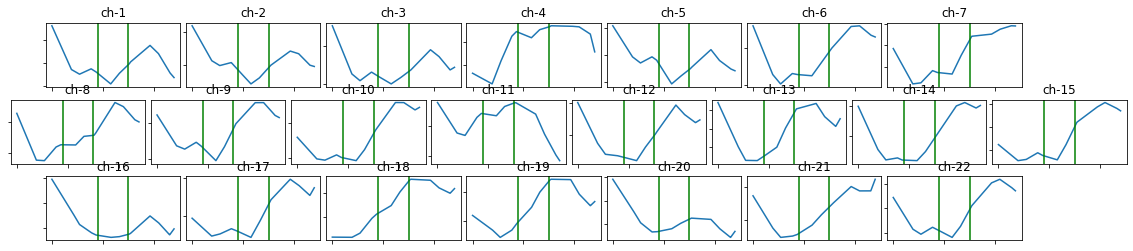

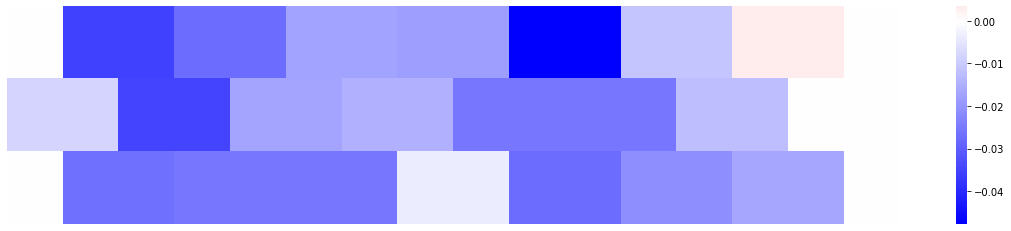




Trial count -> 12


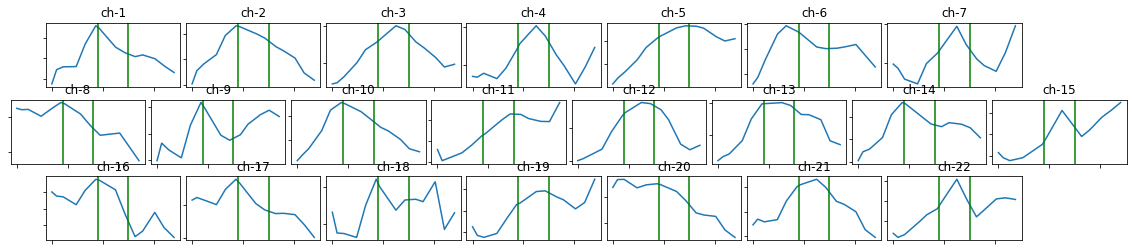

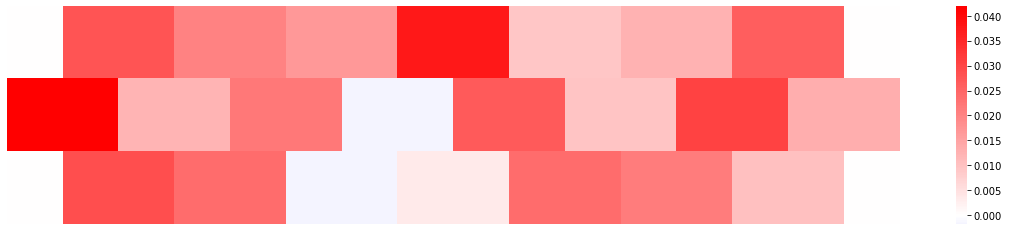




Trial count -> 13


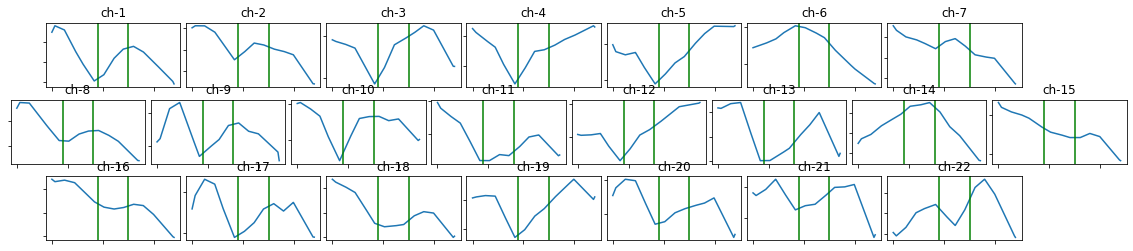

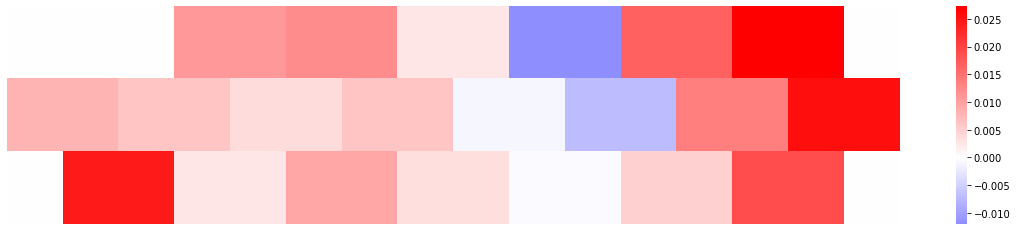




Trial count -> 14


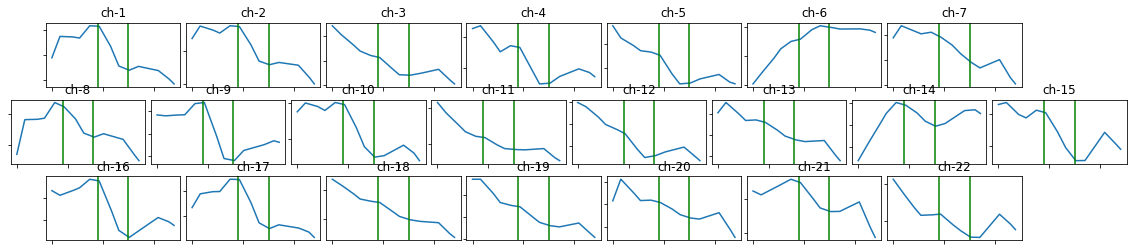

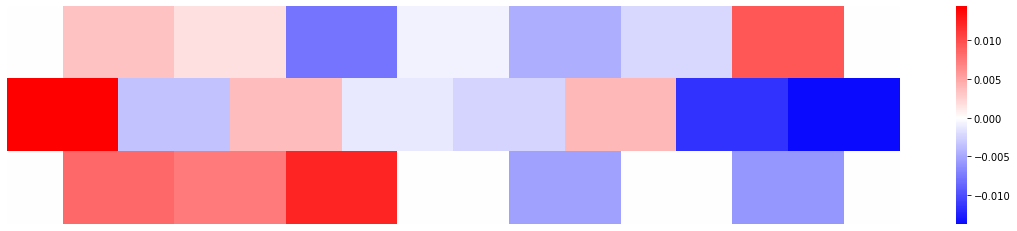




Trial count -> 15


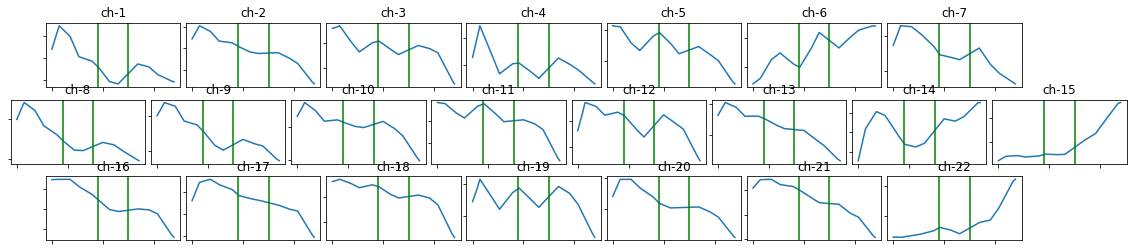

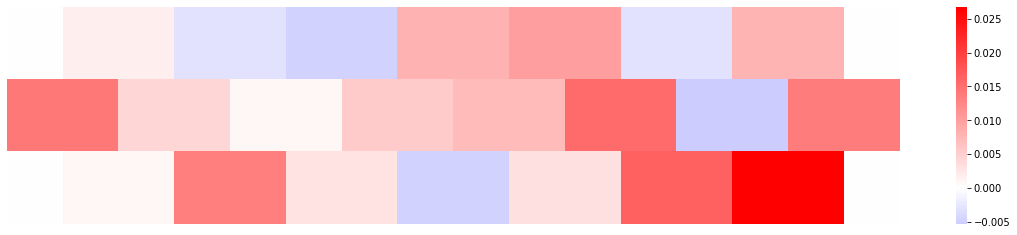




Trial count -> 16


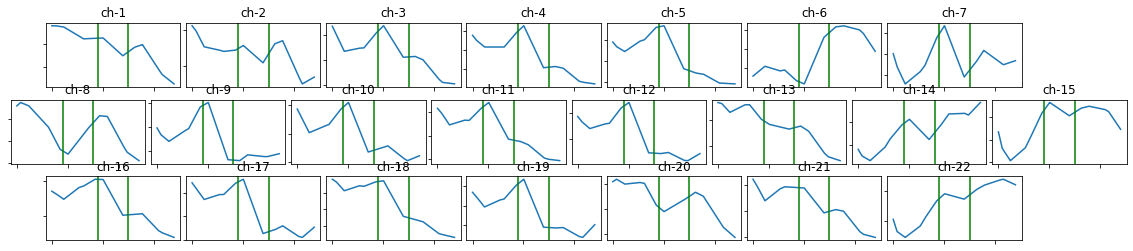

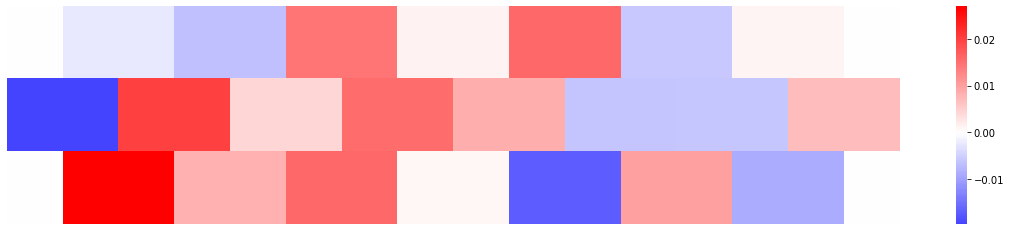




Trial count -> 17


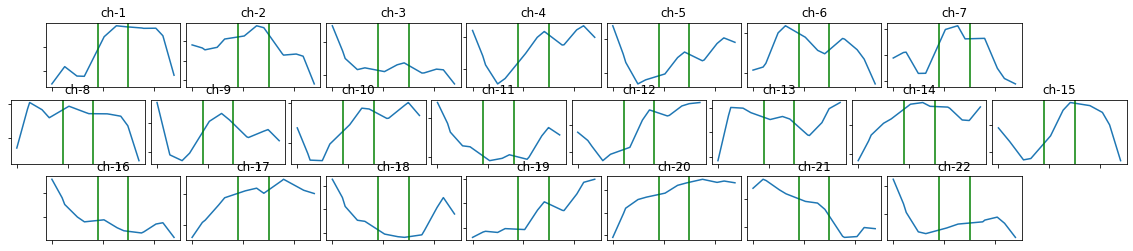

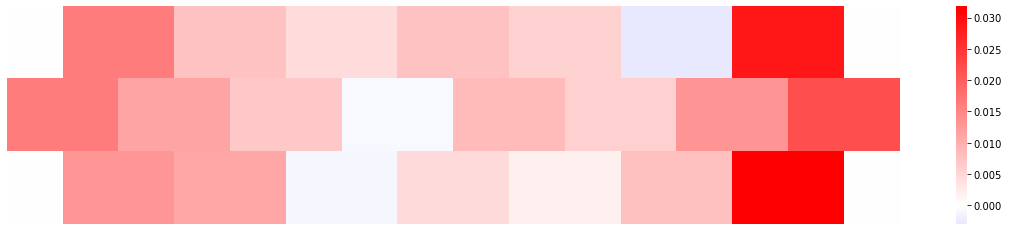




Trial count -> 18


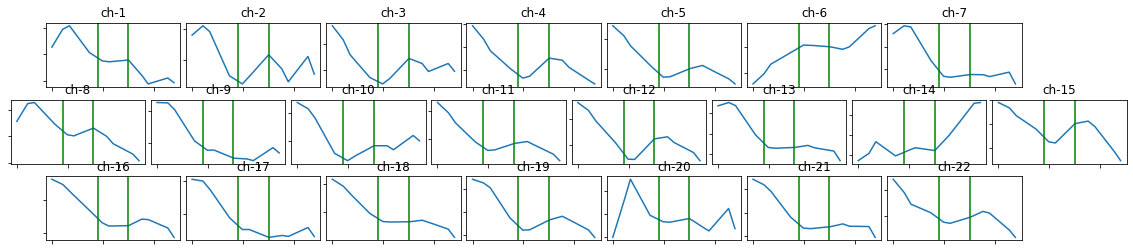

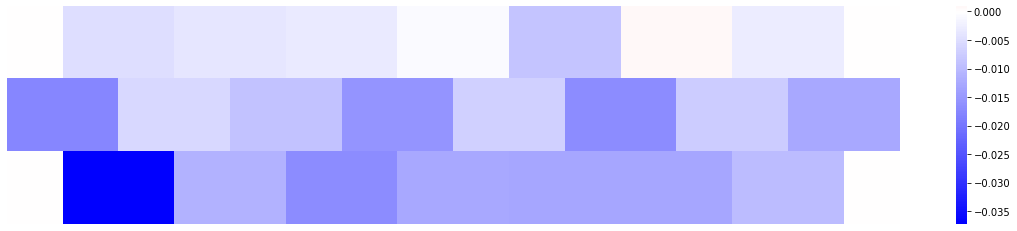




Trial count -> 19


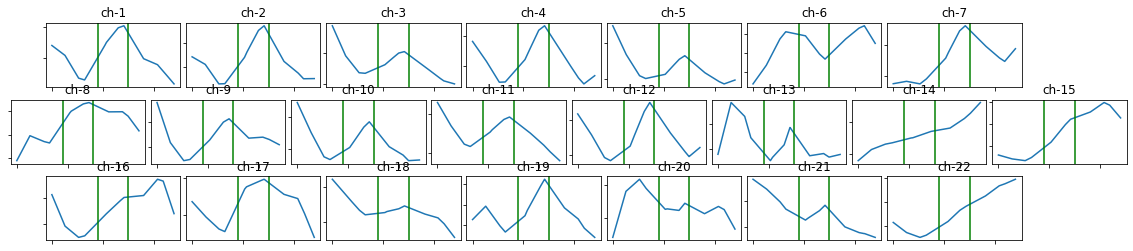

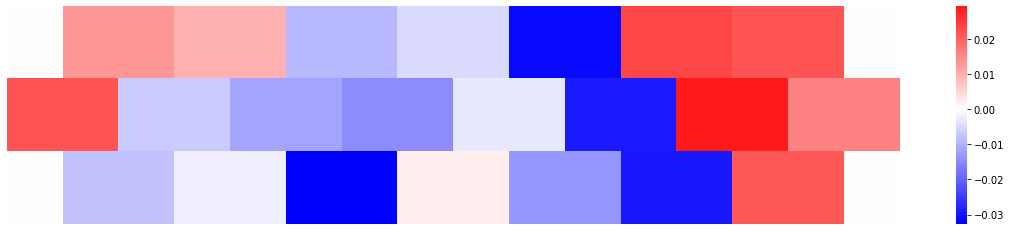




Trial count -> 20


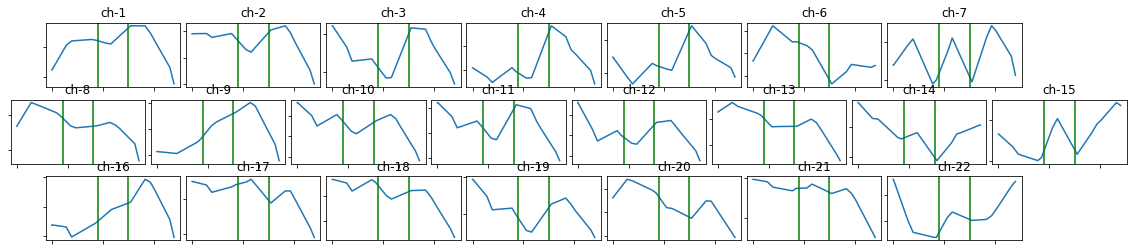

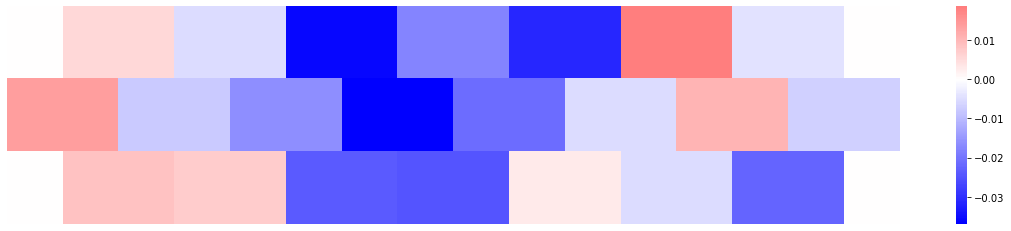

In [22]:
num_trials = int(np.max(oxy_df['trial_count'].values))
for trial_count in range(1, num_trials+1):
    query_statement = 'trial_count == {}'.format(trial_count)
    oxy_df_while_trial = denoised_oxy_df.query(query_statement)
    query_statement = 'trial_count == {} and trial_category == "task"'.format(trial_count)
    oxy_df_while_task = denoised_oxy_df.query(query_statement)
    task_infomations = oxy_df_while_task[info_labels].values
    task_samples = oxy_df_while_task[oxy_value_labels].values.astype(float).T
    task_sample_means = np.mean(task_samples, axis=1)
    normalized_task_samples = np.zeros(task_samples.shape)
    # visualize data
    print('\n\n\nTrial count -> {}'.format(trial_count))
    fig = plt.figure(figsize=(20,4))
    second_row_start_index = 7
    third_row_start_index = 15
    num_colspans = 4
    num_rows = 3
    num_columns = int(num_colspans*np.ceil(num_channels/num_rows))
    for i, channel_label in enumerate(oxy_value_labels):
        samples = oxy_df_while_trial[channel_label].values[:num_trial_samples]
        times = np.linspace(0, 120, samples.shape[0])
        if i < second_row_start_index :
            ax = plt.subplot2grid((num_rows, num_columns), (0, num_colspans*i+1), rowspan=1, colspan=num_colspans)
        elif second_row_start_index <= i and i <= 14:
            ax = plt.subplot2grid((num_rows, num_columns), (1, num_colspans*(i-second_row_start_index)), rowspan=1, colspan=num_colspans)
        elif third_row_start_index <= i:
            ax = plt.subplot2grid((num_rows, num_columns), (2, num_colspans*(i-third_row_start_index)+1), rowspan=1, colspan=num_colspans)
        ax.plot(times, samples)
        ax.axvline(x=times[num_preceding_rest_samples], color='green')
        ax.axvline(x=times[num_preceding_rest_samples+num_task_samples], color='green')
        ax.set_title(channel_label)
        ax.tick_params(
            labelbottom=False,
            labelleft=False,
            labelright=False,
            labeltop=False
        )
    plt.show()
    reshaped_means = np.zeros([3, 16])
    reshaped_means[0,1:15:2] = task_sample_means[:7]
    reshaped_means[0,2:16:2] = task_sample_means[:7]
    reshaped_means[1,0::2] = task_sample_means[7:15]
    reshaped_means[1,1::2] = task_sample_means[7:15]
    reshaped_means[2,1:15:2] = task_sample_means[15:]
    reshaped_means[2,2:16:2] = task_sample_means[15:]
    plt.figure(figsize=(20,4))
    plt.axis("off")
    sns.heatmap(reshaped_means, center=0, cmap='bwr')
    plt.show()


## Calculate correlation




Z-normalized Oxy-Hb data


,experiment_date,trial_count,trial_category,time,ch-1,ch-2,ch-3,ch-4,ch-5,ch-6,...,ch-13,ch-14,ch-15,ch-16,ch-17,ch-18,ch-19,ch-20,ch-21,ch-22
0,0706,1,task,319.8,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0706,1,task,319.95,-1.21199e-05,3.5454e-05,0.000106228,-8.04761e-05,5.86602e-05,9.85203e-05,...,6.70737e-05,0.000198877,8.12898e-05,4.66865e-05,5.66182e-05,0.000184224,9.18673e-05,0.000121589,0.000116558,0.000194418
2,0706,1,task,320.1,-2.42398e-05,7.09079e-05,0.000212456,-0.000160952,0.00011732,0.000197041,...,0.000134147,0.000397753,0.00016258,9.3373e-05,0.000113236,0.000368447,0.000183735,0.000243177,0.000233117,0.000388835
3,0706,1,task,320.25,-3.63598e-05,0.000106362,0.000318684,-0.000241428,0.000175981,0.000295561,...,0.000201221,0.00059663,0.000243869,0.000140059,0.000169855,0.000552671,0.000275602,0.000364766,0.000349675,0.000583253
4,0706,1,task,320.4,-4.84797e-05,0.000141816,0.000424912,-0.000321905,0.000234641,0.000394081,...,0.000268295,0.000795507,0.000325159,0.000186746,0.000226473,0.000736895,0.000367469,0.000486355,0.000466233,0.000777671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0713,20,task,1644.750,0.00817068,0.00272486,0.01704,0.0166587,0.0205645,-0.0161167,...,-0.00630802,-0.0122353,0.000504316,0.00602763,-0.00884611,-0.00616024,0.00543944,-0.0173817,-0.00185879,0.0126096
3996,0713,20,task,1644.900,0.00826525,0.00278913,0.0172453,0.0168292,0.0207753,-0.0162364,...,-0.00630744,-0.0123792,0.000368434,0.00604729,-0.0089536,-0.00609552,0.00555768,-0.0174486,-0.00189474,0.012547
3997,0713,20,task,1645.050,0.00835982,0.0028534,0.0174506,0.0169998,0.0209861,-0.0163562,...,-0.00630686,-0.012523,0.000232552,0.00606696,-0.00906109,-0.0060308,0.00567593,-0.0175156,-0.00193069,0.0124844
3998,0713,20,task,1645.200,0.00845439,0.00291767,0.0176559,0.0171703,0.0211968,-0.0164759,...,-0.00630628,-0.0126669,9.66704e-05,0.00608662,-0.00916859,-0.00596607,0.00579418,-0.0175825,-0.00196664,0.0124218





Oxy-Hb mean with questionnaire results


,trial_count,ch-1,ch-2,ch-3,ch-4,ch-5,ch-6,ch-7,ch-8,ch-9,...,experiment_date,q1,q2,q3,q4,q5,q6,q7,q8,q9
0,1,0.003817,-0.000181,0.006241,-0.008562,0.003296,0.006580,-0.008651,0.014010,0.012713,...,0706,2.0,2.0,3.0,2.0,2.0,3.0,3.0,2.0,2.0
1,2,0.035169,0.003850,0.001954,0.010733,0.001676,-0.015263,0.023316,0.011111,0.008028,...,0706,5.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,5.0
2,3,-0.055624,-0.015720,-0.016409,-0.011180,-0.007519,-0.001251,-0.017659,-0.019656,-0.035743,...,0706,2.0,3.0,3.0,2.0,3.0,3.0,2.0,3.0,3.0
3,4,-0.037892,-0.010329,-0.007056,-0.000823,-0.000095,0.000394,0.003661,-0.018840,-0.019170,...,0706,4.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0
4,5,-0.021546,-0.004346,0.017355,-0.008894,0.011675,0.013873,-0.006439,-0.005761,-0.022862,...,0706,2.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0,3.0
5,6,0.019782,0.005769,0.002769,-0.005082,0.006160,0.008906,0.004182,-0.005375,0.013772,...,0706,5.0,5.0,4.0,5.0,4.0,3.0,5.0,5.0,3.0
6,7,-0.004165,0.001201,0.002529,0.000971,0.000607,0.006521,0.001780,-0.004219,0.004557,...,0706,2.0,2.0,3.0,2.0,2.0,3.0,2.0,2.0,2.0
7,8,0.002826,0.005086,0.007418,0.003504,0.004567,0.007828,0.005586,-0.002836,-0.013332,...,0706,4.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,1.0
8,9,-0.010208,-0.005813,-0.048179,-0.041088,-0.009870,-0.010918,-0.004436,0.000439,-0.001921,...,0706,4.0,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0
9,10,-0.001215,0.007186,0.009551,-0.002659,0.005786,0.014791,0.009184,-0.014867,-0.006632,...,0706,3.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,2.0





Correlations between questionnaire results and Oxy-Hb mean values


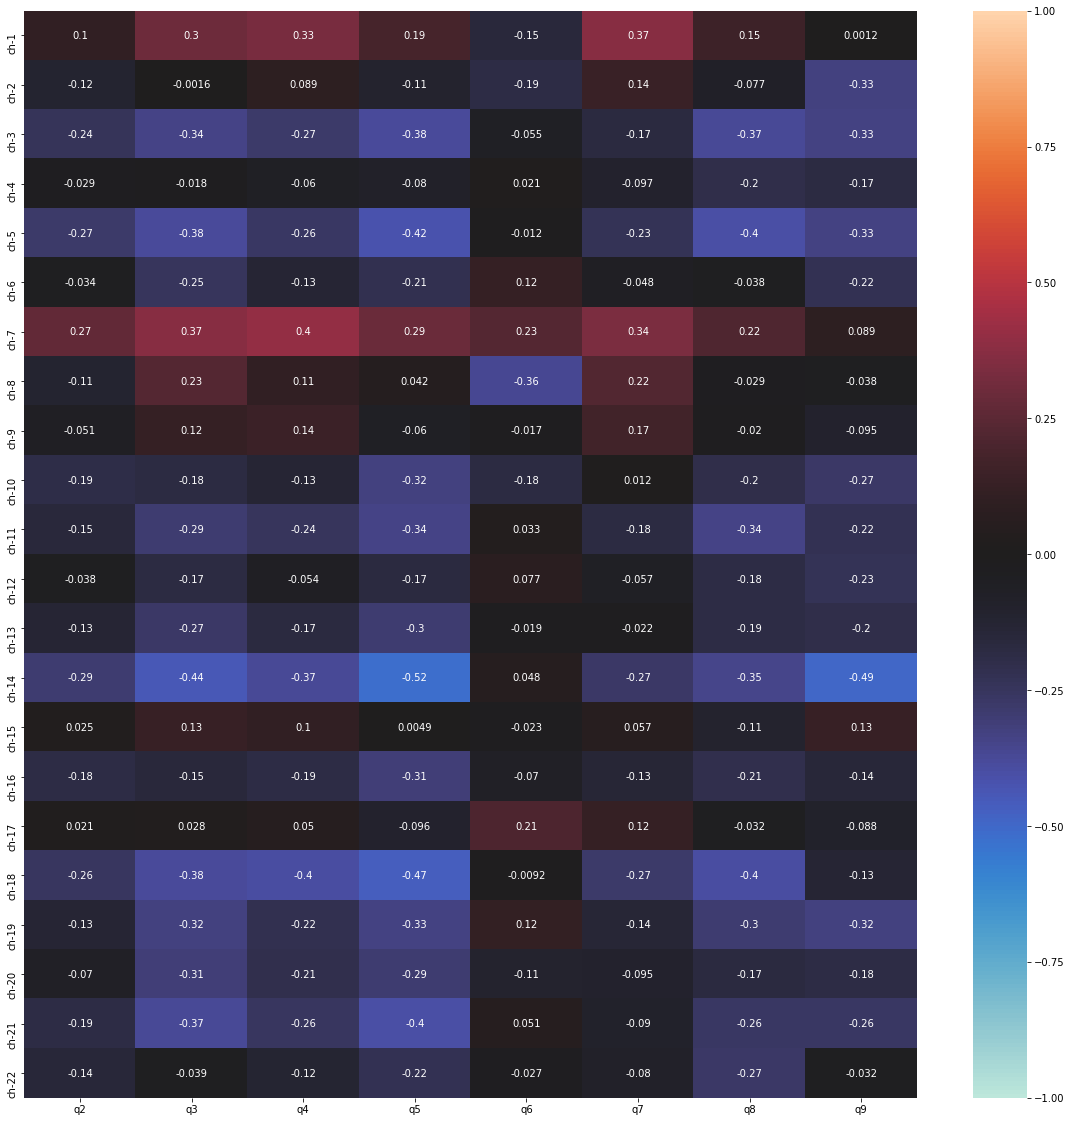




Oxy-Hb variations(task start - task end) with questionnaire results


,trial_count,ch-1,ch-2,ch-3,ch-4,ch-5,ch-6,ch-7,ch-8,ch-9,...,experiment_date,q1,q2,q3,q4,q5,q6,q7,q8,q9
0,1,0.006119,-0.004308,0.007800,-0.020004,0.003031,0.008666,-0.025186,0.029053,0.023022,...,0706,2.0,2.0,3.0,2.0,2.0,3.0,3.0,2.0,2.0
1,2,0.073491,0.013562,0.015459,0.024861,0.009103,-0.019163,0.053838,0.021833,0.021531,...,0706,5.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,5.0
2,3,0.007490,-0.008630,-0.025226,-0.018743,-0.017918,-0.014907,-0.028490,-0.001019,-0.019272,...,0706,2.0,3.0,3.0,2.0,3.0,3.0,2.0,3.0,3.0
3,4,-0.065503,-0.016987,-0.009634,-0.001249,0.000924,0.004236,0.008550,-0.037087,-0.036108,...,0706,4.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0
4,5,-0.041168,-0.009997,0.025648,-0.021866,0.016062,0.024215,-0.021391,-0.010493,-0.052744,...,0706,2.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0,3.0
5,6,0.036005,0.008514,-0.000914,-0.012710,0.007056,0.011227,0.002960,0.003153,0.036200,...,0706,5.0,5.0,4.0,5.0,4.0,3.0,5.0,5.0,3.0
6,7,0.009606,0.007433,0.006468,0.001563,0.006965,0.020390,-0.003094,0.000092,0.020152,...,0706,2.0,2.0,3.0,2.0,2.0,3.0,2.0,2.0,2.0
7,8,0.010169,0.006352,0.011407,0.004833,0.004442,0.008242,0.008672,0.006662,-0.010333,...,0706,4.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,1.0
8,9,-0.008669,-0.007649,-0.059577,-0.050242,-0.008632,-0.017240,-0.005338,0.007815,0.009101,...,0706,4.0,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0
9,10,0.001273,0.009128,0.012180,-0.002718,0.006987,0.019817,0.016364,-0.021999,-0.021548,...,0706,3.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,2.0





Correlations between questionnaire results and Oxy-Hb variations(task start - task end)


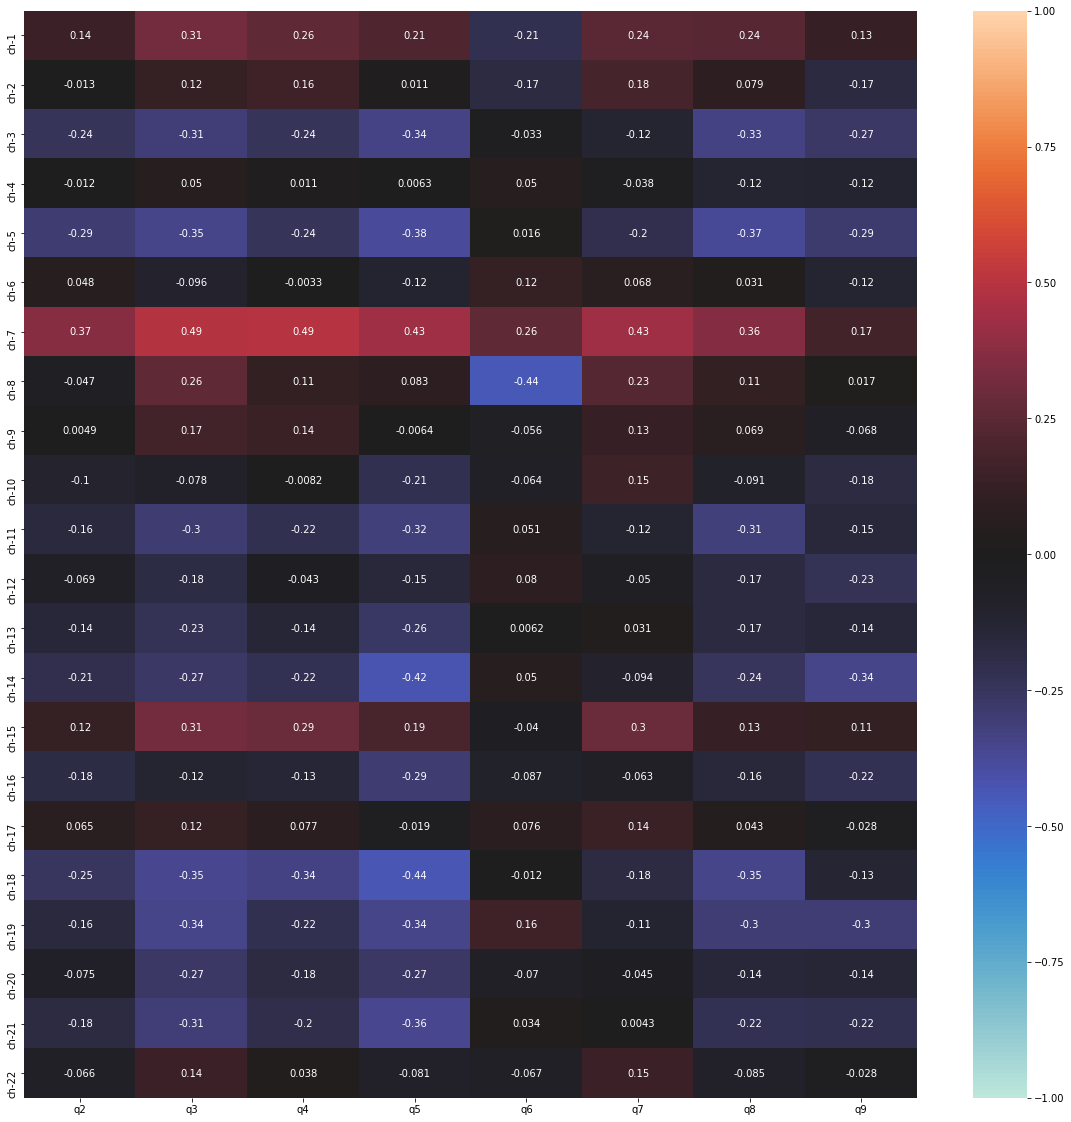

In [23]:
# for each trial, normalize task samples using rest samples and create dataframe.
num_trials = int(np.max(oxy_df['trial_count'].values))
num_information_columns = 4
info_labels = ['experiment_date', 'trial_count', 'trial_category', 'time']
oxy_value_labels = channel_names
normalized_task_samples_array = np.zeros([num_task_samples*num_trials, num_channels])
means_array = np.zeros([num_trials, num_channels])
variations_array = np.zeros([num_trials, num_channels])
task_informations_array = np.full([num_task_samples*num_trials, num_information_columns], '', dtype=object)
for trial_count in range(1, num_trials+1):
    query_statement = 'trial_count == {}'.format(trial_count)
    oxy_df_while_trial = denoised_oxy_df.query(query_statement)
    query_statement = 'trial_count == {} and trial_category == "task"'.format(trial_count)
    oxy_df_while_task = denoised_oxy_df.query(query_statement)
    task_infomations = oxy_df_while_task[info_labels].values
    task_samples = oxy_df_while_task[oxy_value_labels].values.astype(float).T
    task_sample_means = np.mean(task_samples, axis=1)
    normalized_task_samples = np.zeros(task_samples.shape)
    for i in range(task_samples.shape[0]):
        normalized_task_samples[i] = task_samples[i]-task_samples[i, 0]
    normalized_task_samples_array[(trial_count-1)*200:trial_count*200, :] = normalized_task_samples.T
    task_informations_array[(trial_count-1)*200:trial_count*200, :] = task_infomations
    means_array[(trial_count-1):trial_count, :] = np.mean(normalized_task_samples, axis=1)
    variations_array[(trial_count-1):trial_count, :] = normalized_task_samples[:, -1] - normalized_task_samples[:, 0]
normalized_task_sample_df = pd.DataFrame(
    np.hstack([task_informations_array, normalized_task_samples_array]),
    columns=oxy_df.columns.values
)
print('\n\n\nZ-normalized Oxy-Hb data')
display(normalized_task_sample_df)

# calculate correlations between questionnaire results and Oxy-Hb mean values
mean_df = pd.DataFrame(
    means_array,
    columns=oxy_value_labels
)
mean_df.insert(0, 'trial_count', (np.arange(len(questionnaire_result_df))+1).astype(str))
mean_df.to_csv('./mean.csv')
mean_with_questionnaire_result_df = pd.merge(mean_df, questionnaire_result_df, on='trial_count')
print('\n\n\nOxy-Hb mean with questionnaire results')
display(mean_with_questionnaire_result_df)
print('\n\n\nCorrelations between questionnaire results and Oxy-Hb mean values')
questionnaire_and_mean_correlations = mean_with_questionnaire_result_df.corr().loc[oxy_value_labels,questionnaire_result_df.columns.values[3:]]
plt.figure(figsize=(20,20))
sns.heatmap(questionnaire_and_mean_correlations, vmax=1, vmin=-1, center=0, annot=True)
plt.show()
questionnaire_and_mean_correlations.to_csv('./mean-correlation.csv')

# calculate correlation between questionnaire results and Oxy-Hb variations(task start - task end)
variation_df = pd.DataFrame(
    variations_array,
    columns=oxy_value_labels
)
variation_df.insert(0, 'trial_count', (np.arange(len(variation_df))+1).astype(str))
variation_df.to_csv('./variation.csv')
variation_with_questionnaire_result_df = pd.merge(variation_df, questionnaire_result_df, on='trial_count')
print('\n\n\nOxy-Hb variations(task start - task end) with questionnaire results')
display(variation_with_questionnaire_result_df)
print('\n\n\nCorrelations between questionnaire results and Oxy-Hb variations(task start - task end)')
questionnaire_and_variation_correlations = variation_with_questionnaire_result_df.corr().loc[oxy_value_labels,questionnaire_result_df.columns.values[3:]]
plt.figure(figsize=(20,20))
sns.heatmap(questionnaire_and_variation_correlations, vmax=1, vmin=-1, center=0, annot=True)
plt.show()
questionnaire_and_variation_correlations.to_csv('./variation-correlation.csv')
    